# Speech separation using masking techniques
Given a speech sample from each of two speakers, use NMF to separate the signal associated with each speaker

In [1]:
import numpy as np
import librosa
from IPython.display import Audio
from scipy.signal import stft, istft
import matplotlib.pyplot as plt

%matplotlib inline

## Learn NMF representation for speaker 1

In [9]:
S1, sr = librosa.load('/root/shared/Box/wsj0-mix-subset/2spk8kmax/cv/s1/011o0314_1.8471_20ka010d_-1.8471.wav')

In [10]:
Audio(S1, rate=sr)

### Represent speech as a fourier transformed matrix

In [11]:
_, _, Z1 = stft(S1)

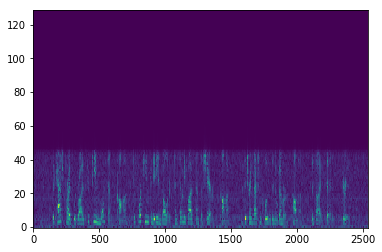

In [12]:
plt.imshow(abs(Z1)**.5, aspect='auto', origin='lower')
#plt.ylim(0,45); # limited at 45 to provide better visibility to range of speech frequencies

### Iterative function to calculate basis vectors ($S1W$) and activations ($S1H$) for speaker 1

In [13]:
def nmf(X, max_iter=10000, bv=30):

    from numpy import random
    W = random.rand(X.shape[0],bv)
    H = random.rand(bv,X.shape[1])
    
    Ws = []
    Hs = []

    for i in range(max_iter):

        Wfrac = np.dot((X/np.dot(W,H)), H.T) / np.dot(np.ones((X.shape[0],X.shape[1])),H.T)
        Wnew = np.multiply(W, Wfrac)
        Wnew = np.where(Wnew==0, 1e-20, Wnew)

        Hfrac = np.dot(Wnew.T, (X/np.dot(Wnew,H))) / np.dot(Wnew.T, np.ones((X.shape[0],X.shape[1])))
        Hnew = np.multiply(H, Hfrac)
        Hnew = np.where(Hnew==0, 1e-20, Hnew)

        Ws.append(Wnew)
        Hs.append(Hnew)

        if len(Ws)>1:
            if np.all(np.isclose(Ws[-2],Ws[-1], .01, .01)):
                break

        W = Wnew
        H = Hnew

    return W, H

In [14]:
S1W, S1H = nmf(Z1)

## Learn NMF representation for speaker 2

In [15]:
S2, sr = librosa.load('/root/shared/Box/wsj0-mix-subset/2spk8kmax/cv/s2/011o0314_1.8471_20ka010d_-1.8471.wav')

### Represent speech as a fourier transformed matrix

In [16]:
f, t, Z2 = stft(S2)

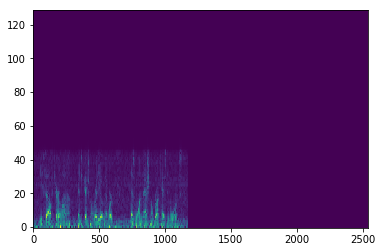

In [17]:
plt.imshow(abs(Z2)**.5, aspect='auto', origin='lower')
#plt.ylim(0,45); # limited at 45 to provide better visibility to range of speech frequencies

### Iterative function to calculate basis vectors ($S2W$) and activations ($S2H$) for speaker 2

In [18]:
S2W, S2H = nmf(Z2)

## Mixed signal containing speech from speaker 1 and 2

In [19]:
X, sr = librosa.load('/root/shared/Box/wsj0-mix-subset/2spk8kmax/cv/mix/011o0314_1.8471_20ka010d_-1.8471.wav')

In [20]:
Audio(X, rate=sr)

### Fourier transformed representation of mixed signal (speakers 1 and 2)

In [21]:
_, _, ZX = stft(X)

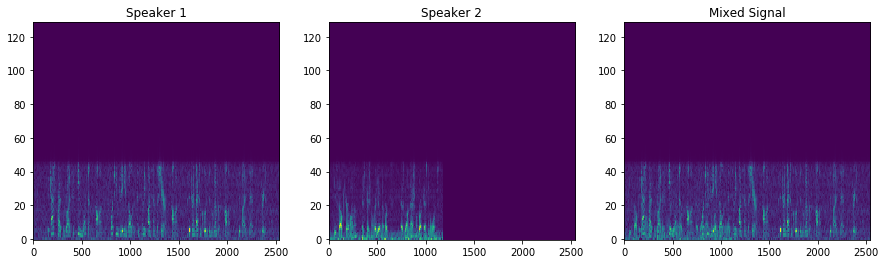

In [22]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].imshow(abs(Z1)**.5, aspect='auto', origin='lower')
ax[0].set_title('Speaker 1')
#ax[0].set_ylim(0,45)
ax[1].imshow(abs(Z2)**.5, aspect='auto', origin='lower')
#ax[1].set_ylim(0,45)
ax[1].set_title('Speaker 2')
ax[2].imshow(abs(ZX)**.5, aspect='auto', origin='lower')
#ax[2].set_ylim(0,45)
ax[2].set_title('Mixed Signal');

## Calculate activation (H) for basis vectors representing each speaker (W1, W2) 

In [23]:
W1W2 = np.concatenate((S1W, S2W), axis=1)

In [24]:
def nmfh(X, Wnew, max_iter=1000):

    from numpy import random
    H = random.rand(Wnew.shape[1],X.shape[1])
    
    Hs = []
    Wnew = np.where(Wnew==0, 1e-20, Wnew)
    
    for i in range(max_iter):

        Hfrac = np.dot(Wnew.T, (X/np.dot(Wnew,H))) / np.dot(Wnew.T, np.ones((X.shape[0],X.shape[1])))
        Hnew = np.multiply(H, Hfrac)
        Hnew = np.where(Hnew==0, 1e-20, Hnew)

        Hs.append(Hnew)

        if len(Hs)>1:
            if np.all(np.isclose(Hs[-2],Hs[-1], .01, .01)):
                break

        H = Hnew

    return H

### Iterative function to calculate activations only (using basis vectors representing each speaker)

In [25]:
WSWNH = nmfh(ZX, W1W2)

## Use mixed speech activations to create a mask for each speaker

### Applying the class approach

In [26]:
M1 = np.dot(S1W,WSWNH[:30,:]) / np.dot(W1W2, WSWNH)
M2 = np.dot(S2W,WSWNH[30:60,:]) / np.dot(W1W2, WSWNH)
SX1 = np.multiply(M1,ZX)
SX2 = np.multiply(M2,ZX)
_, speaker1 = istft(SX1)
_, speaker2 = istft(SX2)

In [27]:
Audio(speaker1, rate=sr)

Calculate the Signal Noise Ratio using:
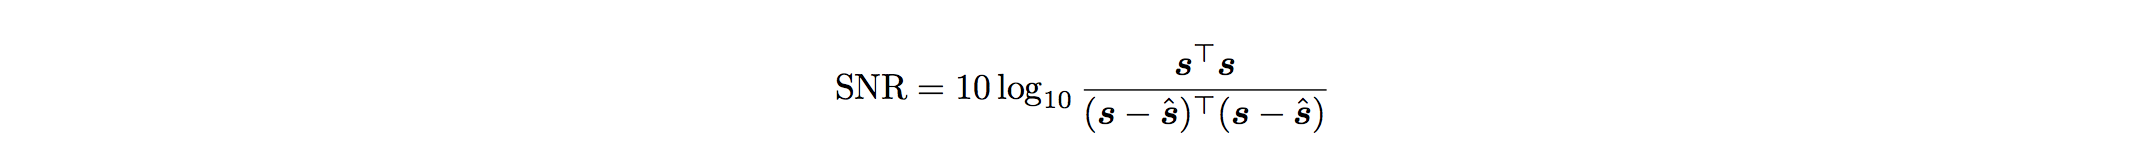


In [28]:
SNR1 = np.dot(X.T,X) / np.dot((X-speaker1[:324885]).T, X-speaker1[:324885])
SNR1

8.096139971809428

### Ideal Ratio Mask

In [29]:
IRM = (Z1**2/(Z1**2+ZX**2))**.5

In [30]:
sound = ZX*IRM

In [31]:
_, speaker1 = istft(sound)

In [32]:
Audio(speaker1, rate=sr)

In [34]:
SNR1 = np.dot(X.T,X) / np.dot((X-speaker1[:324885]).T, X-speaker1[:324885])
SNR1

4.3487616

### Complex Ideal Ratio Mask

In [35]:
cIRM_r = ((np.real(ZX)*np.real(Z1)) + (np.imag(ZX)*np.imag(Z1)))/(np.real(ZX)**2 + np.imag(ZX)**2)

In [36]:
cIRM_i = (np.real(ZX)*np.imag(Z1) - np.imag(ZX)*np.real(Z1)) / (np.real(ZX)**2 + np.imag(ZX)**2)

In [37]:
cIRM = cIRM_r+cIRM_i*1j

In [38]:
sound = ZX*cIRM

In [39]:
_, speaker1 = istft(sound)

In [41]:
Audio(speaker1, rate=sr)

In [40]:
SNR1 = np.dot(X.T,X) / np.dot((X-speaker1[:324885]).T, X-speaker1[:324885])
SNR1

4.511635

## Visualize the Magnitude Spectrum

(0, 0.4)

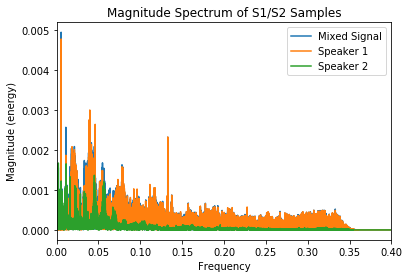

In [42]:
plt.magnitude_spectrum(X, label='Mixed Signal')
plt.magnitude_spectrum(S1, label='Speaker 1')
plt.magnitude_spectrum(S2, label='Speaker 2')
plt.title('Magnitude Spectrum of S1/S2 Samples')
plt.legend()
plt.xlim(0, .4)

## Apply the same complex IRM mask to a different mixed sample 

### Load new mixed sample (58409) and perform STFT

In [43]:
X, sr = librosa.load('/root/shared/Box/wsj0-mix-subset/2spk8kmax/cv/mix/01na0112_0.58409_015a0101_-0.58409.wav')

In [44]:
Audio(X, rate=sr)

In [45]:
_, _, ZX = stft(X)

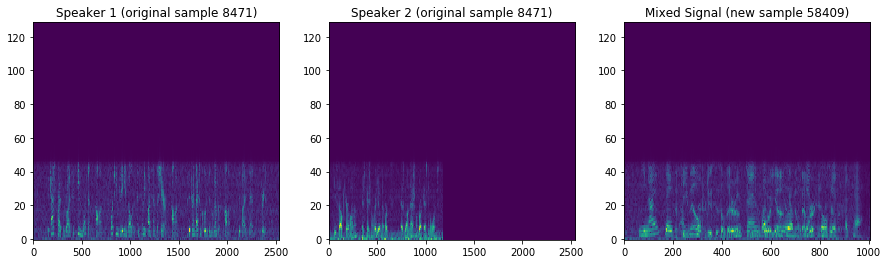

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))

ax[0].imshow(abs(Z1)**.5, aspect='auto', origin='lower')
ax[0].set_title('Speaker 1 (original sample 8471)')
#ax[0].set_ylim(0,45)
ax[1].imshow(abs(Z2)**.5, aspect='auto', origin='lower')
#ax[1].set_ylim(0,45)
ax[1].set_title('Speaker 2 (original sample 8471)')
ax[2].imshow(abs(ZX)**.5, aspect='auto', origin='lower')
#ax[2].set_ylim(0,45)
ax[2].set_title('Mixed Signal (new sample 58409)');

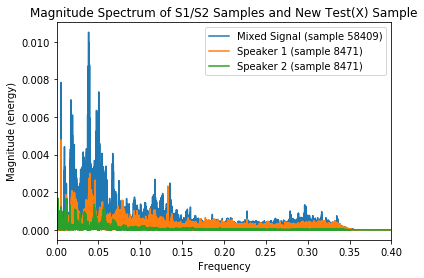

In [61]:
plt.magnitude_spectrum(X, label='Mixed Signal (sample 58409)')
plt.magnitude_spectrum(S1, label='Speaker 1 (sample 8471)')
plt.magnitude_spectrum(S2, label='Speaker 2 (sample 8471)')
plt.title('Magnitude Spectrum of S1/S2 Samples and New Test(X) Sample')
plt.legend()
plt.xlim(0, .4);

### Generate cIRM mask using new mixed sample and original S1 sample (trimmed to length of new sample)

In [49]:
cIRM_r = ((np.real(ZX)*np.real(Z1[:,:1006])) + (np.imag(ZX)*np.imag(Z1[:,:1006])))/(np.real(ZX)**2 + np.imag(ZX)**2)

In [50]:
cIRM_i = (np.real(ZX)*np.imag(Z1[:,:1006]) - np.imag(ZX)*np.real(Z1[:,:1006])) / (np.real(ZX)**2 + np.imag(ZX)**2)

In [52]:
cIRM = cIRM_r+cIRM_i*1j

### Transform new sample using max based on original S1 sample

In [53]:
sound = ZX*cIRM

In [54]:
_, speaker1 = istft(sound)

### Compare mixed sample with recovered S1 sample created with mask from different S1 sample
#### Audio of mized sample 58409

In [58]:
Audio(X, rate=sr)

#### Audio of speaker 1 sample 8471

In [55]:
Audio(speaker1, rate=sr)

In [57]:
SNR1 = np.dot(X.T,X) / np.dot((X-speaker1[:128574]).T, X-speaker1[:128574])
SNR1

0.7009747